# Introduction and Project Objective

This project is the M-5 forecasting competion on www.kaggle.com.  The objective is to forecast 28 days of sales.  Walmart donated sales data from January 29, 2011 to June 19, 2016.  The sales data is hierarchical data set.  The following graphic shows how the data set is broken down.

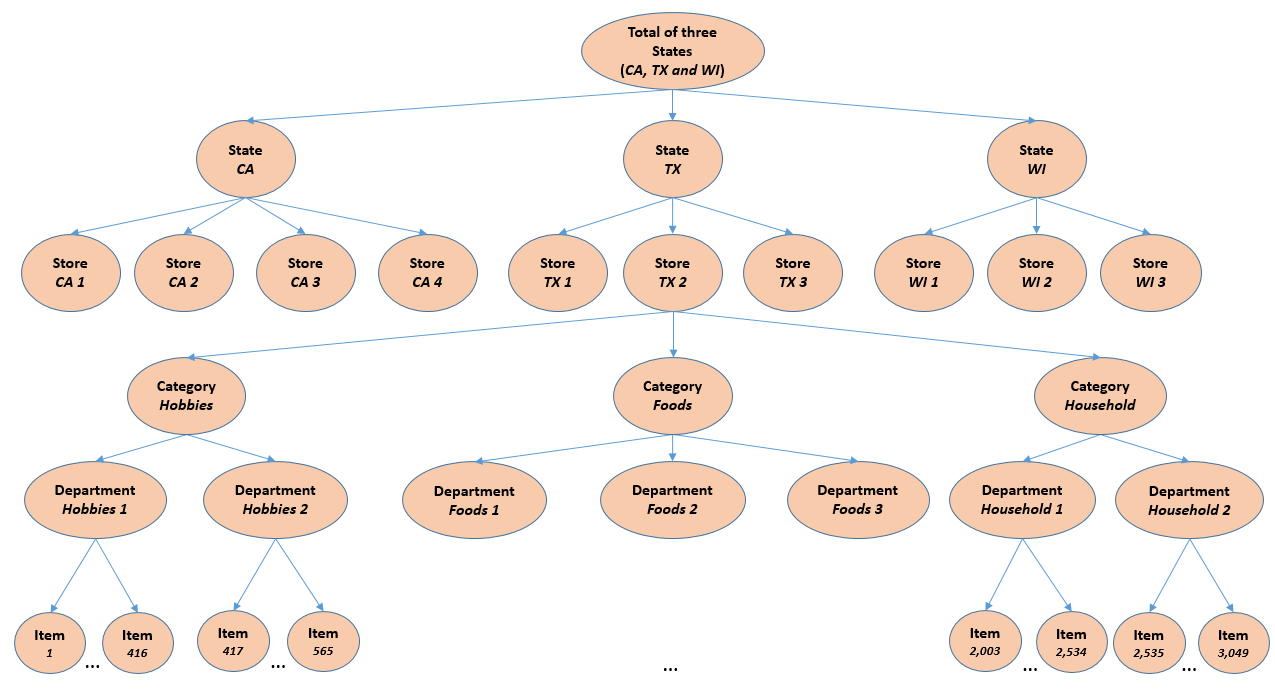

Graphic retrieved from M5 forecasting competition guide book.

In this dataset, the products are sold in California, Texas, and Wisconsin.  There are four stores in California, three stores in Texas, and three stores  in Wisonsin.  The products sold are from three different categories: hobbies, foods, and household.  


References:
Retrieved from:

https://www.kaggle.com/tarunpaparaju/m5-competition-eda-models

https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration

https://www.kaggle.com/zachary3141/m5-beginner-eda-cnn

https://www.machinelearningplus.com/time-series/time-series-analysis-python/

https://www.kaggle.com/ratan123/m5-forecasting-lightgbm-with-timeseries-splits

https://www.kaggle.com/thomasadorfer/m5-preliminary-eda

https://www.kaggle.com/artgor/it-is-time-for-m5-going-step-by-step

https://www.kaggle.com/tpmeli/visual-guide-3-m5-baselines-eda-sarima

https://www.kaggle.com/beezus666/end-to-end-data-wrangling

https://www.kaggle.com/sampath1310/m5-eda-interactive

# Dataset Description

## File 1: calendar.csv
Contains the dates on which products are sold. The dates are in a yyyy/dd/mm format.

date: The date in a “y-m-d” format.

wm_yr_wk: The id of the week the date belongs to.

weekday: The type of the day (Saturday, Sunday, ..., Friday).

wday: The id of the weekday, starting from Saturday.

month: The month of the date.

year: The year of the date.

event_name_1: If the date includes an event, the name of this event.

event_type_1: If the date includes an event, the type of this event.

event_name_2: If the date includes a second event, the name of this event.

event_type_2: If the date includes a second event, the type of this event.

snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP 3 purchases on the examined date. 1 indicates that SNAP purchases are allowed.

## File 2: sales_train_validation.csv
Contains the historical daily unit sales data per product and store [d_1 - d_1913].

item_id: The id of the product.

dept_id: The id of the department the product belongs to.

cat_id: The id of the category the product belongs to.

store_id: The id of the store where the product is sold.

state_id: The State where the store is located.
d_1, d_2, ..., d_i, ... d_1941: The number of units sold at day i, starting from 2011-01-29.

## File 3: sell_prices.csv
Contains information about the price of the products sold per store and date.

store_id: The id of the store where the product is sold.

item_id: The id of the product.

wm_yr_wk: The id of the week.

sell_price: The price of the product for the given week/store. The price is 
provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. 

Note that although prices are constant at weekly basis, they may change through time (both training and test set).

## File 4: submission.csv
Demonstrates the correct format for submission to the competition.

Each row contains an id that is a concatenation of an item_id and a store_id, which is either validation (corresponding to the Public leaderboard), or evaluation (corresponding to the Private leaderboard). You are predicting 28 forecast days (F1-F28) of items sold for each row. For the validation rows, this corresponds to d_1914 - d_1941, and for the evaluation rows, this corresponds to d_1942 - d_1969. (Note: a month before the competition close, the ground truth for the validation rows will be provided.)

Retrieved from:
www.kaggle.com/gopidurgaprasad/m5-forecasting-eda

# Load Libraries

In [1]:
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from pathlib import Path
from sklearn.utils import shuffle
import tqdm as tqdm
import regex as re

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
pd.plotting.register_matplotlib_converters()
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
### Beginning of fast.ai functions ###
'''
These helper and data cleaning functions are from a fast.ai course.
The repository is here: https://github.com/fastai/fastai/tree/master/old.
Retrieved from www.kaggle.com/beezus666/end-to-end-data-wrangling.
'''

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)
        
def make_date(df, date_field:str):
    "Make sure 'df[field_name]' is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)
        
def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):
    '''
    add_datepart converts a column of df from a datetime64 to many columns
    containing the information from the date.  This applies changes inplace.
    '''
    if isinstance(fldnames, str):
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64
        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                   'Is_month_end', 'Is_month_start', 'Is_quarter_end',
                   'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)
                
def ifnone (a,b):
    '''
    (a:Any, b:Any) -> Any
    'a' if 'a' is not None, otherwise 'b'.
    '''
    return b if a is None else a

### End of fast.ai functions ###

In [3]:
def reduce_mem_usage(df, verbose=True):
    '''
    Function retrieved from www.kaggle.com/siavrez/fe-pipeline.
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Calendar Dataframe

In [4]:
# Load calendar dataframe.
calendar_df = pd.read_csv('calendar.csv')

In [5]:
# Display first few rows of calendar_df.
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,1/29/2011,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,1/30/2011,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,1/31/2011,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2/1/2011,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2/2/2011,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [6]:
# Display last few rows of calendar_df.
calendar_df.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,6/15/2016,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,6/16/2016,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,6/17/2016,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,6/18/2016,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,6/19/2016,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [7]:
# Display information about each column in calendar_df.
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.4+ KB


In [8]:
# Number of rows and columns for calendar_df.
calendar_df.shape

(1969, 14)

In [9]:
# Check for missing values.
calendar_df.isnull().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

# Selling Price Dataframe

In [10]:
# Load selling prices dataset.
selling_prices_df = pd.read_csv('sell_prices.csv') 

In [11]:
# Display the first few rows of selling_prices_df.
selling_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [12]:
# Display the last few rows of selling_prices_df.
selling_prices_df.tail()

,store_id,item_id,wm_yr_wk,sell_price
6841116,WI_3,FOODS_3_827,11617,1.0
6841117,WI_3,FOODS_3_827,11618,1.0
6841118,WI_3,FOODS_3_827,11619,1.0
6841119,WI_3,FOODS_3_827,11620,1.0
6841120,WI_3,FOODS_3_827,11621,1.0


In [13]:
# Display information about each column in selling_prices_df.
selling_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
store_id      object
item_id       object
wm_yr_wk      int64
sell_price    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [14]:
# Number of rows and columns for selling_prices_df.
selling_prices_df.shape

(6841121, 4)

In [15]:
# Check for missing values.
selling_prices_df.isnull().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

# Sales Dataframe

In [16]:
# Load sales train validation dataset.
sales_train_valid_df = pd.read_csv('sales_train_validation.csv')

In [17]:
# Display the first few rows of the sales_train_valid_df.
sales_train_valid_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [18]:
# Display the last few rows of the sales_train_valid_df.
sales_train_valid_df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3
30489,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Display the information of each column of sales_train_valid_df.
sales_train_valid_df.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
d_1          int64
d_2          int64
d_3          int64
d_4          int64
d_5          int64
d_6          int64
d_7          int64
d_8          int64
d_9          int64
d_10         int64
d_11         int64
d_12         int64
d_13         int64
d_14         int64
d_15         int64
d_16         int64
d_17         int64
d_18         int64
d_19         int64
d_20         int64
d_21         int64
d_22         int64
d_23         int64
d_24         int64
             ...  
d_1884       int64
d_1885       int64
d_1886       int64
d_1887       int64
d_1888       int64
d_1889       int64
d_1890       int64
d_1891       int64
d_1892       int64
d_1893       int64
d_1894       int64
d_1895       int64
d_1896       int64
d_1897       int64
d_1898       int64
d_1899       int64
d_1900       int64
d_1901       int64
d_1902       int64
d_1903       int64
d_1904       int64
d_1905      

In [20]:
# Display the number of rows and columns for sales_train_valid_df.
sales_train_valid_df.shape

(30490, 1919)

In [21]:
# Check for missing values.
sales_train_valid_df.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
state_id    0
d_1         0
d_2         0
d_3         0
d_4         0
d_5         0
d_6         0
d_7         0
d_8         0
d_9         0
d_10        0
d_11        0
d_12        0
d_13        0
d_14        0
d_15        0
d_16        0
d_17        0
d_18        0
d_19        0
d_20        0
d_21        0
d_22        0
d_23        0
d_24        0
           ..
d_1884      0
d_1885      0
d_1886      0
d_1887      0
d_1888      0
d_1889      0
d_1890      0
d_1891      0
d_1892      0
d_1893      0
d_1894      0
d_1895      0
d_1896      0
d_1897      0
d_1898      0
d_1899      0
d_1900      0
d_1901      0
d_1902      0
d_1903      0
d_1904      0
d_1905      0
d_1906      0
d_1907      0
d_1908      0
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

# Calendar Dataframe

In [22]:
# Load sample_submission dataset.
sample_sub_df = pd.read_csv('sample_submission.csv')

In [23]:
# Display the first few rows of sample_sub_df.
sample_sub_df.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Display the last few rows of sample_sub_df.
sample_sub_df.tail()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60979,FOODS_3_827_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Summary Statistics

Retrieved from: https://www.kaggle.com/anirbansen3027/m5-forecasting-eda-beginner

In [27]:
# Create a variable for dates.
date_col = [col for col in sales_train_valid_df if col.startswith('d_')]

CA    12196
TX     9147
WI     9147
Name: state_id, dtype: int64


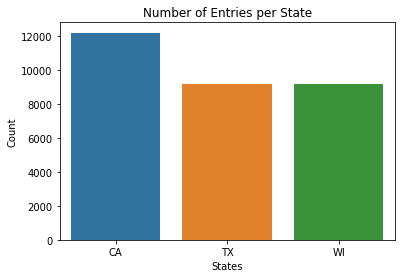

In [34]:
# Count the number of data entries for CA, TX, and WI.
sales_state_count = sales_train_valid_df.state_id.value_counts()
print(sales_state_count)

# Create bar plot for the state counts.
sns.countplot('state_id', data=sales_train_valid_df)
plt.xlabel('States')
plt.ylabel('Count')
plt.title('Number of Entries per State')
plt.show()

In [37]:
# Display the percentages for the number of data entries for CA, TX, and WI.
percent_state = sales_train_valid_df.state_id.value_counts()/sales_train_valid_df.shape[0] * 100
print(percent_state)

# # Create a bar plot for the percent of state counts.
# # Create bar plot for the state counts.
# sns.countplot(, data=sales_train_valid_df)
# plt.xlabel('States')
# plt.ylabel('Count')
# plt.title('Number of Entries per State')
# plt.show()

CA    40.0
TX    30.0
WI    30.0
Name: state_id, dtype: float64


In [38]:
# Sum the sales to create a new column called sales.
sales_train_valid_df['total_sales'] = sales_train_valid_df[date_col].sum(axis=1)

In [40]:
# Display the total sales for each state.
sales_train_valid_df.groupby('state_id').agg({'total_sales':'sum'}).reset_index()

,state_id,total_sales
0,CA,28675547
1,TX,18899006
2,WI,18120856


In [41]:
# Display the total sales as percentages for each state.
sales_train_valid_df.groupby('state_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100

,total_sales
state_id,
CA,43.649240
TX,28.767621
WI,27.583139


In [42]:
# Display the total sales as percentages for each store.
sales_train_valid_df.groupby('store_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100

,total_sales
store_id,
CA_1,11.718043
CA_2,8.654296
CA_3,17.030383
CA_4,6.246519
TX_1,8.517021
TX_2,10.981565
TX_3,9.269034
WI_1,7.837781
WI_2,9.961141


In [43]:
# Display the total sales for each category.
sales_train_valid_df.groupby('cat_id').agg({'total_sales':'sum'}).reset_index()

,cat_id,total_sales
0,FOODS,45089939
1,HOBBIES,6124800
2,HOUSEHOLD,14480670


In [44]:
# Display the total sales as percentages for each category.
sales_train_valid_df.groupby('cat_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100

,total_sales
cat_id,
FOODS,68.634840
HOBBIES,9.323026
HOUSEHOLD,22.042134


In [45]:
# Create a table to display total sales percentages for each category in each state.
sales_train_valid_df.groupby(['cat_id', 'state_id']).agg({'total_sales':'sum'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

total_sales                      
state_id           CA         TX         WI
cat_id                                     
FOODS       42.573360  28.734616  28.692024
HOBBIES     49.632364  25.998220  24.369416
HOUSEHOLD   44.468674  30.041745  25.489580

In [46]:
# Create a table to display total sales percentages for each state in each category.
sales_train_valid_df.groupby(['state_id', 'cat_id']).agg({'total_sales':'sum'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

total_sales                      
cat_id         FOODS    HOBBIES  HOUSEHOLD
state_id                                  
CA         66.943107  10.600959  22.455934
TX         68.556098   8.425517  23.018385
WI         71.394067   8.236796  20.369137

In [47]:
# Display the total sales as percentages for each department.
sales_train_valid_df.groupby('dept_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100

,total_sales
dept_id,
FOODS_1,7.744896
FOODS_2,11.613935
FOODS_3,49.276010
HOBBIES_1,8.518799
HOBBIES_2,0.804227
HOUSEHOLD_1,17.505829
HOUSEHOLD_2,4.536305


In [48]:
# Create a table to display total sales percentages for each state in each category.
sales_train_valid_df.groupby(['store_id', 'dept_id']).agg({'total_sales':'sum'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

total_sales                                                         \
dept_id      FOODS_1    FOODS_2    FOODS_3  HOBBIES_1 HOBBIES_2 HOUSEHOLD_1   
store_id                                                                      
CA_1        7.376371  11.498041  51.022666  10.671615  0.716452   14.291168   
CA_2       12.623167   5.852088  42.737907  10.171235  1.046878   19.468066   
CA_3        6.586076  10.748540  49.841547   7.914764  0.674185   19.190548   
CA_4        8.371275  13.093504  47.240084  13.204210  0.550653   12.937790   
TX_1        6.535066  11.286507  49.703215   6.899086  0.769576   20.478574   
TX_2        7.048641  10.831999  51.634984   7.771571  1.044109   17.384977   
TX_3        6.757065  12.385139  49.224726   7.553655  1.105064   19.053607   
WI_1        9.840666  11.668028  45.267585  11.810365  0.923916   15.981066   
WI_2        8.113585  16.696776  48.052953   5.019734  0.637560   18.562283   
WI_3        6.204706  12.624853  54.767834   6.627481  0.632691   15.831682   

                      
dept_id  HOUSEHOLD_2  
store_id              
CA_1        4.423687  
CA_2        8.100660  
CA_3        5.044341  
CA_4        4.602483  
TX_1        4.327978  
TX_2        4.283720  
TX_3        3.920743  
WI_1        4.508375  
WI_2        2.917110  
WI_3        3.310753

# EDA

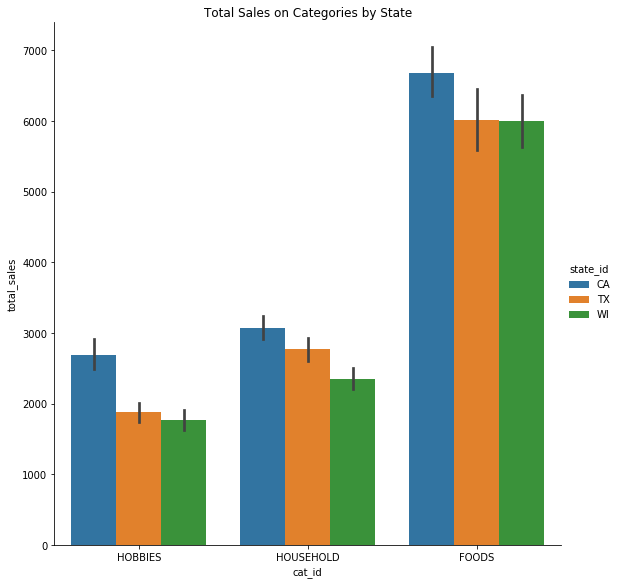

In [49]:
### Retrieved from: https://www.kaggle.com/zachary3141/m5-beginner-eda-cnn ###
sales_train_valid_df['total_sales'] = sales_train_valid_df.sum(axis=1)
sns.catplot(x='cat_id', y='total_sales',
           hue='state_id',
           data=sales_train_valid_df, kind='bar',
           height=8, aspect=1)
plt.title('Total Sales on Categories by State')
plt.show()

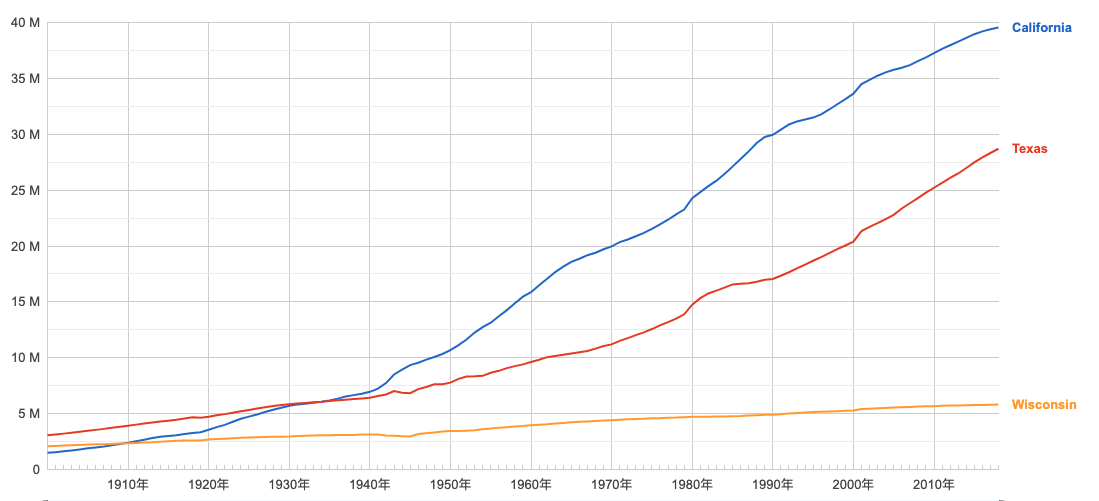

Retrieved from: https://i.imgur.com/bUSEoMb.png

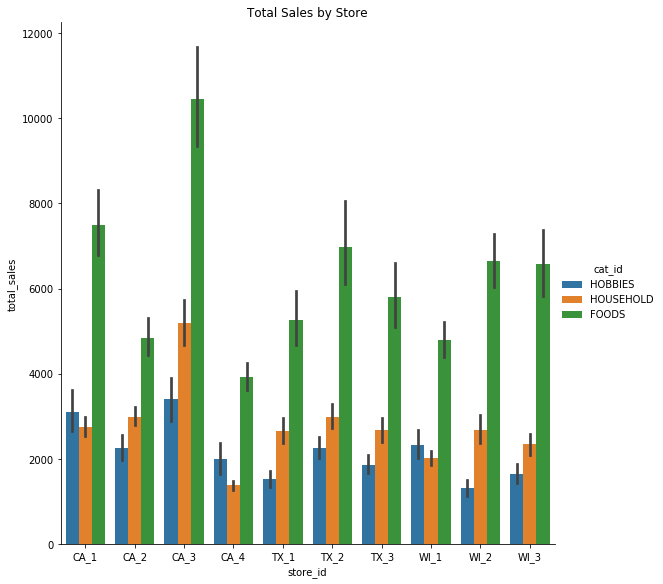

In [50]:
### Retrieved from: https://www.kaggle.com/zachary3141/m5-beginner-eda-cnn ###
sns.catplot(x='store_id', y='total_sales',
           hue='cat_id',
           data=sales_train_valid_df, kind='bar',
           height=8, aspect=1)
plt.title('Total Sales by Store')
plt.show()

In [51]:
### Retrieved from: https://www.kaggle.com/zachary3141/m5-beginner-eda-cnn ###
hobbies_state = sales_train_valid_df.loc[(sales_train_valid_df['cat_id'] == 'HOBBIES')].groupby(['state_id']).mean().T
hobbies_state = hobbies_state.rename({'CA': 'HOBBIES_CA', 'TX': 'HOBBIES_TX', 'WI': 'HOBBIES_WI'}, axis=1)
household_state = sales_train_valid_df.loc[(sales_train_valid_df['cat_id'] == 'HOUSEHOLD')].groupby(['state_id']).mean().T
household_state = household_state.rename({'CA': 'HOUSEHOLD_CA', 'TX': 'HOUSEHOLD_TX', 'WI': 'HOUSEHOLD_WI'}, axis=1)
foods_state = sales_train_valid_df.loc[(sales_train_valid_df['cat_id'] == 'FOODS')].groupby(['state_id']).mean().T
foods_state = foods_state.rename({'CA': 'FOODS_CA', 'TX': 'FOODS_TX', 'WI': 'FOODS_WI'}, axis=1)
nine_example = pd.concat([hobbies_state, household_state, foods_state], axis=1)
nine_example = nine_example.drop('total_sales')

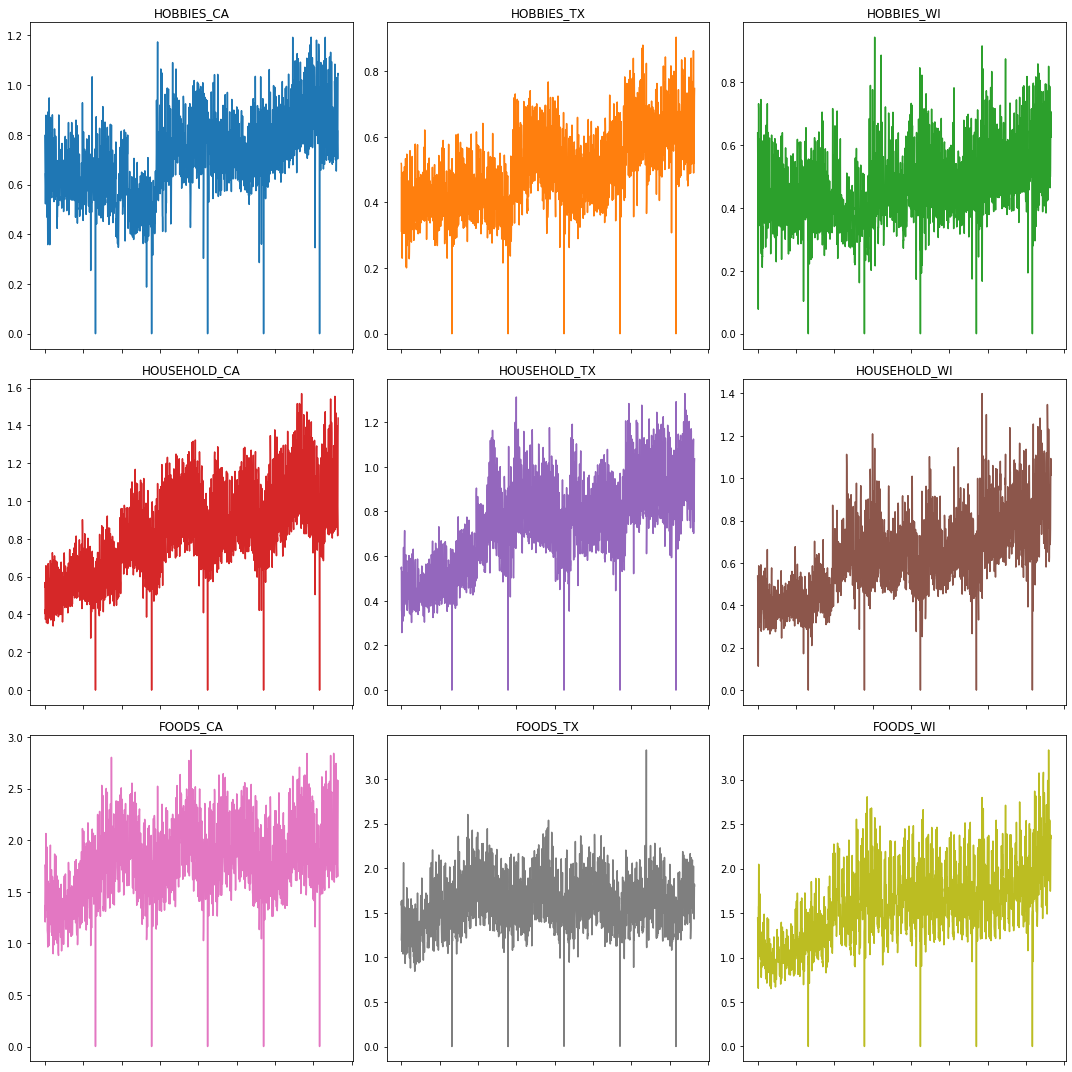

In [52]:
### Retrieved from: https://www.kaggle.com/zachary3141/m5-beginner-eda-cnn ###
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.flatten()
ax_idx = 0
for item in nine_example.columns:
    nine_example[item].plot(title=item, color=next(color_cycle), ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

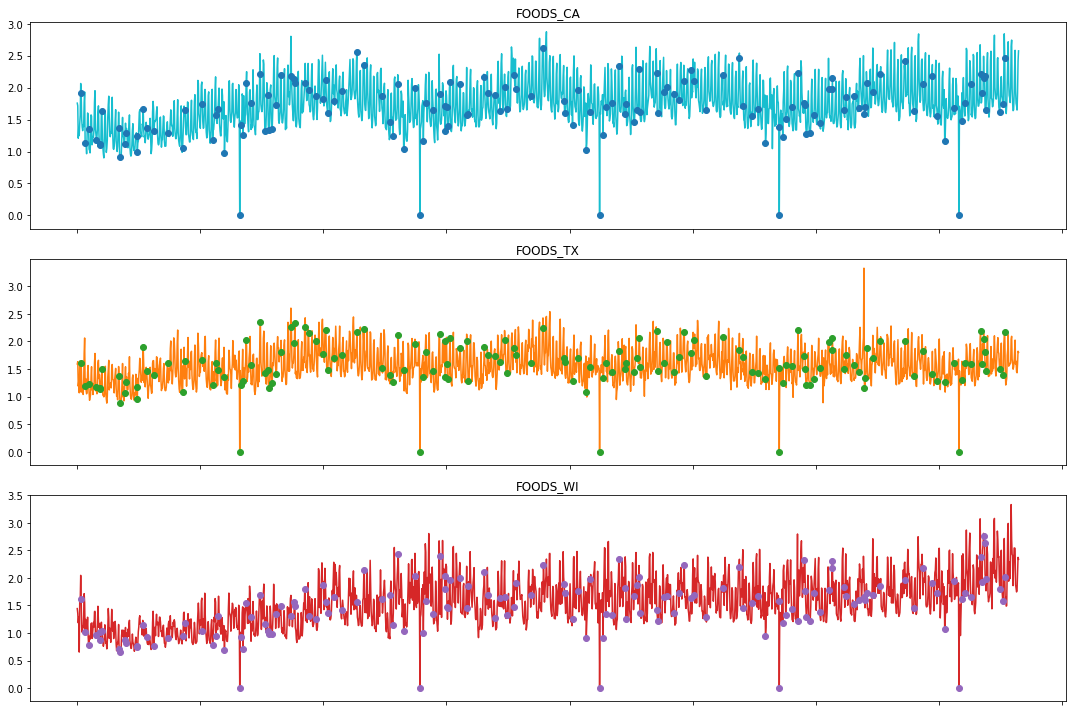

In [55]:
event_date = calendar_df.loc[calendar_df['event_name_1'].isin(calendar_df.event_name_1.unique()[1:])].d
FOODS_event = sales_train_valid_df.loc[(sales_train_valid_df['cat_id'] == 'FOODS')].groupby(['state_id']).mean().T.reset_index()
FOODS_event = FOODS_event.loc[FOODS_event['index'].isin(event_date)]
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
nine_example['FOODS_CA'].plot(title='FOODS_CA', color=next(color_cycle))
plt.scatter(FOODS_event.reset_index().level_0, FOODS_event['CA'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,2)
nine_example['FOODS_TX'].plot(title='FOODS_TX', color=next(color_cycle))
plt.scatter(FOODS_event.reset_index().level_0, FOODS_event['TX'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,3)
nine_example['FOODS_WI'].plot(title='FOODS_WI', color=next(color_cycle))
plt.scatter(FOODS_event.reset_index().level_0, FOODS_event['WI'],color=next(color_cycle), zorder=10)
plt.tight_layout()
plt.show()

Target looks like classification
Showing only top 10 of 1909 continuous features
Linear Discriminant Analysis training set score: 0.447


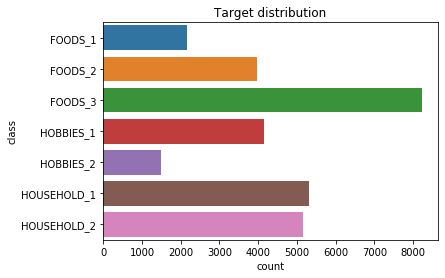

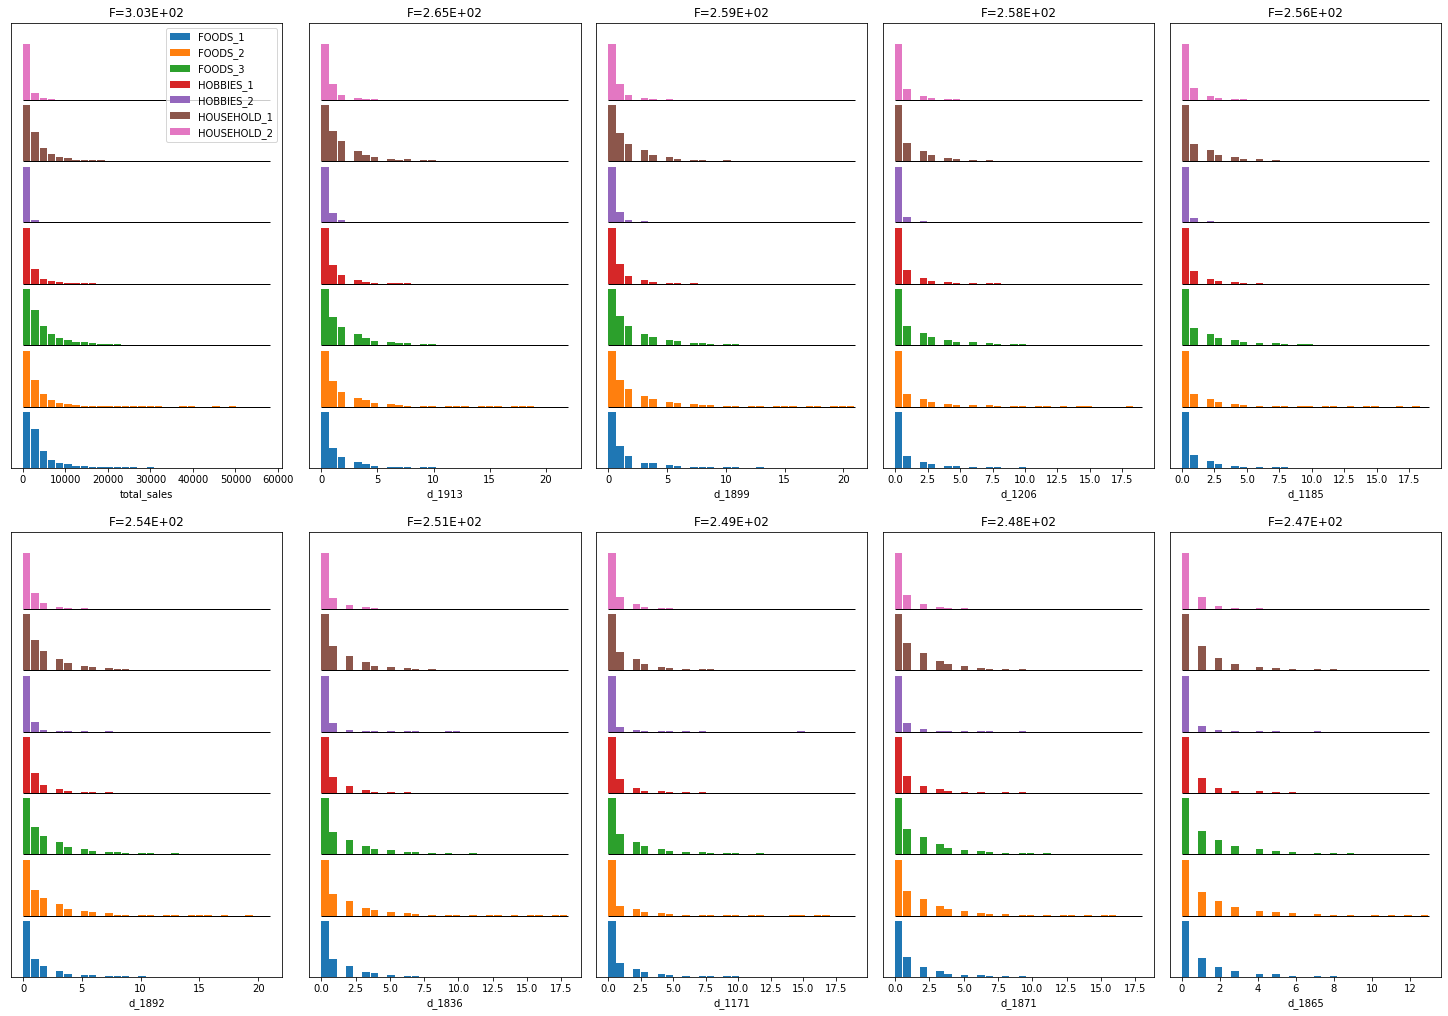

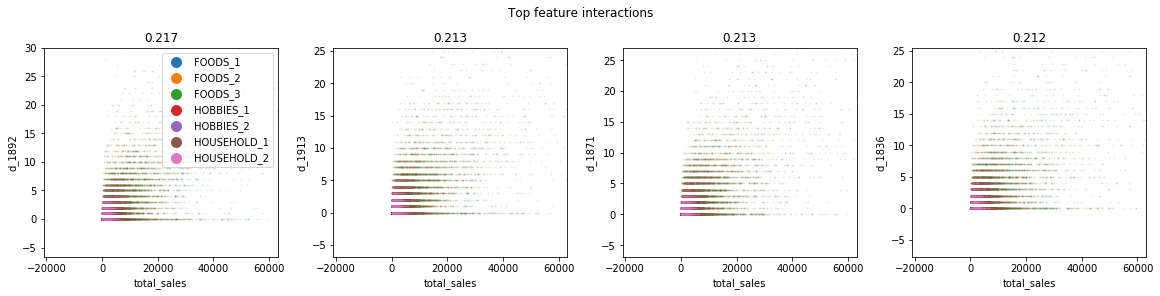

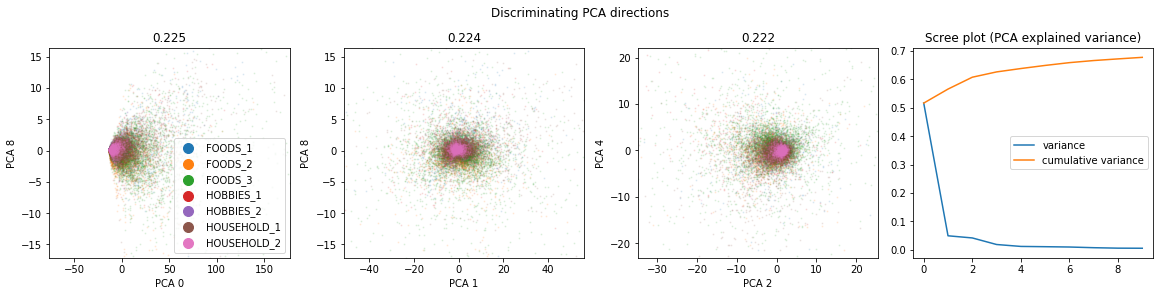

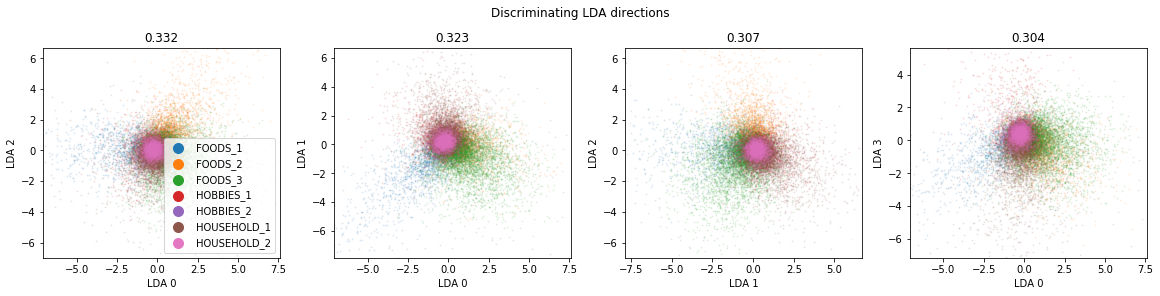

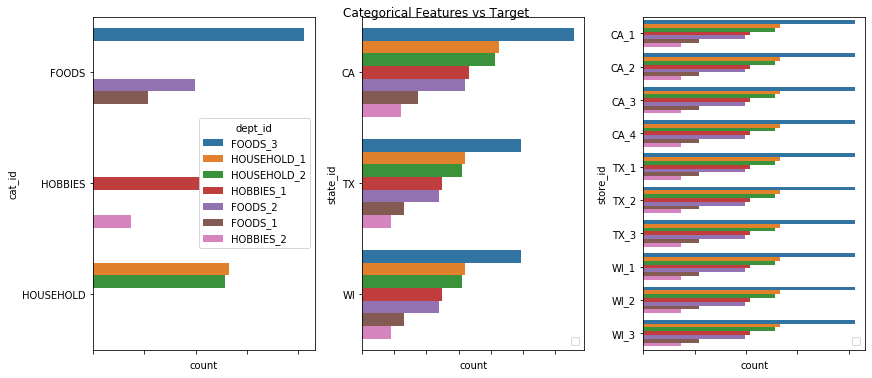

In [57]:
### Retrieved from: https://www.kaggle.com/deepakdeepu8978/m5-competition-explore-eda-models ###
from dabl import plot

plot(sales_train_valid_df, 'dept_id')
plt.show()

In [86]:
### Retrieved from: https://www.kaggle.com/gopidurgaprasad/m5-forecasting-eda-lstm-pytorch-modeling ###
# Store for this analysis will CA_2.


In [78]:
new_CA_2.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,...,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
'''
Preparing the data for modeling.
Retrieved from: https://www.kaggle.com/beezus666/end-to-end-data-wrangling 
''' 
# Get all columns that aren't day columns
list_id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] 
df_d_cols = sales_train_valid_df.drop(list_id_vars, axis=1)
df_d_cols.columns

Index(['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10',
       ...
       'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911',
       'd_1912', 'd_1913', 'total_sales'],
      dtype='object', length=1914)

In [80]:
# Using melt to create new rows.
%time df_melted_sales = sales_train_valid_df.melt(id_vars = list_id_vars, value_vars = df_d_cols.columns, var_name = 'd', value_name = 'sales') 

Wall time: 11.7 s


In [81]:
# Display the top rows of the resulting melted sales data.
df_melted_sales.head() 

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [82]:
# These columns are redundant to id so dropping them.
df_melted_sales.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1, inplace = True) 
df_melted_sales.head()

,id,d,sales
0,HOBBIES_1_001_CA_1_validation,d_1,0
1,HOBBIES_1_002_CA_1_validation,d_1,0
2,HOBBIES_1_003_CA_1_validation,d_1,0
3,HOBBIES_1_004_CA_1_validation,d_1,0
4,HOBBIES_1_005_CA_1_validation,d_1,0


In [83]:
# Drop 'id' column.
sub_cols = sample_sub_df.drop(['id'], axis=1).columns

# Melting the submission df. 
df_melted_sub = sample_sub_df.melt(id_vars = ['id'], value_vars = sub_cols, 
                                    var_name = 'd', value_name = 'sales') 
df_melted_sub.head()

,id,d,sales
0,HOBBIES_1_001_CA_1_validation,F1,0
1,HOBBIES_1_002_CA_1_validation,F1,0
2,HOBBIES_1_003_CA_1_validation,F1,0
3,HOBBIES_1_004_CA_1_validation,F1,0
4,HOBBIES_1_005_CA_1_validation,F1,0


In [84]:
# Replace F with space.
df_melted_sub['d'] = df_melted_sub['d'].str.replace('F','')
df_melted_sub.head()

,id,d,sales
0,HOBBIES_1_001_CA_1_validation,1,0
1,HOBBIES_1_002_CA_1_validation,1,0
2,HOBBIES_1_003_CA_1_validation,1,0
3,HOBBIES_1_004_CA_1_validation,1,0
4,HOBBIES_1_005_CA_1_validation,1,0


In [85]:
# As per the contest notes, this should end at "d_1941," so that's what we should see here...
df_melted_sub.tail() 

,id,d,sales
1707435,FOODS_3_823_WI_3_evaluation,28,0
1707436,FOODS_3_824_WI_3_evaluation,28,0
1707437,FOODS_3_825_WI_3_evaluation,28,0
1707438,FOODS_3_826_WI_3_evaluation,28,0
1707439,FOODS_3_827_WI_3_evaluation,28,0
